# House Prices - Advanced Regression Techniques (kaggle competition)
Predict sales prices and practice feature engineering

In [227]:
# import necessary packages
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statistics as stats
import scipy.stats
import statsmodels.api as sm
from scipy.stats import pearsonr
from scipy.linalg import lu
from statsmodels.formula.api import ols
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pickle

# suppress warnings
import warnings
warnings.filterwarnings('ignore')


In [87]:
# set columns rows view max
pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

## Import the dataset

In [88]:
# import dataset
df_train=pd.read_csv("./data/train.csv")

Let's look at datatypes and also see which columns have null values.<br>
Columns that have a great deal may need to be dropped, those without that many could be imputed.

In [89]:
# look at datatypes
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Move target `SalePrice` column to second position for easy viewing.

In [90]:
# remove col and save
move_col=df_train.pop('SalePrice')

# insert col
df_train.insert(1,'SalePrice',move_col)

#preview results
df_train.iloc[:,:10].head()

,Id,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour
0,1,208500,60,RL,65.0,8450,Pave,NaN,Reg,Lvl
1,2,181500,20,RL,80.0,9600,Pave,NaN,Reg,Lvl
2,3,223500,60,RL,68.0,11250,Pave,NaN,IR1,Lvl
3,4,140000,70,RL,60.0,9550,Pave,NaN,IR1,Lvl
4,5,250000,60,RL,84.0,14260,Pave,NaN,IR1,Lvl


## Check for Null

In [91]:
df_train.isnull().sum()

Id                  0
SalePrice           0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF  

Columns that have null values:
- `LotFrontage`: Linear feet of street connected to property - 259
-  `Alley`: Type of alley access to property - 1369
- `BsmtQual` - 37
- `BsmtCond`- 37
- `BsmtExposure` - 38
- `BsmtFinType1` - 37
- `BsmtFinType2` - 38
- `Electrical` - 1
- `FireplaceQu`: Fireplace quality - 690
- `GarageType` - 81
- `GarageYrBlt` - 81
- `GarageFinish`- 81
- `GarageQual` - 81
- `GarageCond` - 81
- `PoolQC`: Pool Quality - 1453
- `Fence`: Fence quality - 1179
- `MiscFeature`: Miscellaneous feature not covered in other categories - 1406


Looks like they mainly have to do with `Basements`, `Garages`, `Pool`, `Alley`, `MISC`, `Fence` and `LotFrontage`.<br>
They are all objects, except for `LotFrontage` (numerical continous), `GarageYrBlt`(numeric categorical) which are float because of NaN.

### Impute Nulls
I will drop an columns with outrageous amounts of NaN, impute for numeric, and impute as `Unknown` for object datatypes that I feel like will have some value to the model.

In [92]:
# drop col list
drop_null = ['Alley','FireplaceQu','PoolQC','Fence','MiscFeature']

# drop cols
df_train.drop(columns=drop_null, axis=1, inplace=True)

In [93]:
# impute numeric
imputer = SimpleImputer(missing_values=np.NaN, strategy="median")
df_train["LotFrontage"] = imputer.fit_transform(df_train["LotFrontage"].values.reshape(-1,1))[:,0]

In [94]:
# impute categorical
df_train=df_train.fillna("Unknown")

In [95]:
# check for null
df_train.isnull().sum().any()

False

## Exploratory Data Analysis
Here we will look at some descriptive statistic plots to get a better feel for our data.

### Box Plots
Let's look at a few key variables distributions

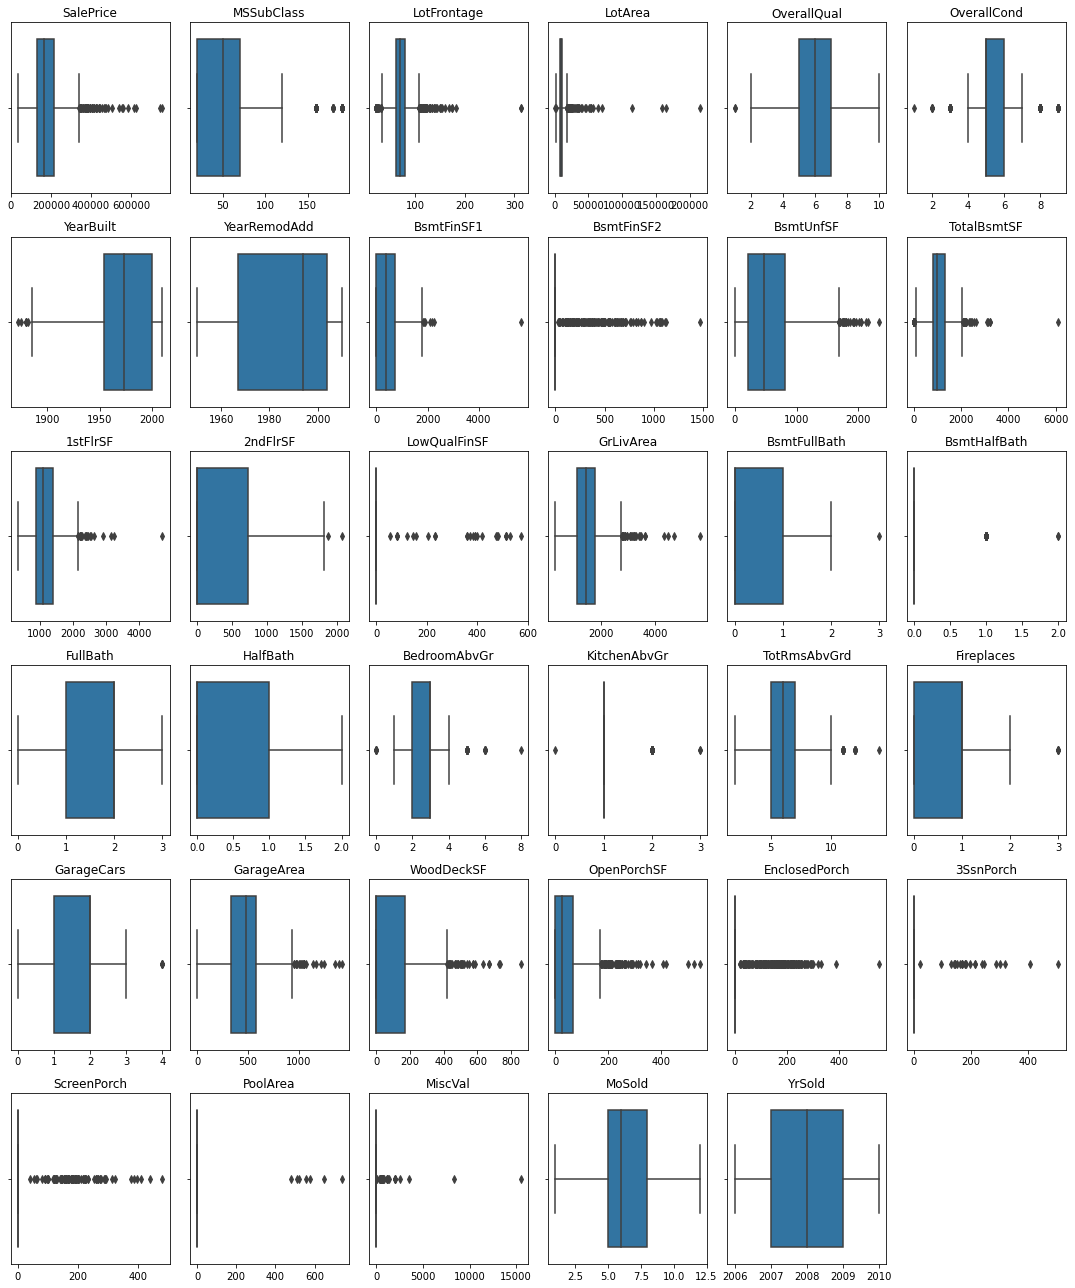

In [96]:
# function to iterate through num cols and create boxplots
def draw_boxplot_grid(df):
    num_cols = df.select_dtypes(include='number').columns
    num_plots = len(num_cols)
    num_rows = math.ceil(num_plots / 6)
    
    fig, axs = plt.subplots(num_rows, 6, figsize=(15, num_rows * 3))
    axs = axs.flatten()
    
    for i, column in enumerate(num_cols):
        ax = axs[i]
        sns.boxplot(x=column, orient='v', data=df, ax=ax)
        ax.set_title(column)
        ax.set_xlabel("")
    
    # remove any unused subplots
    if num_plots < len(axs):
        for j in range(num_plots, len(axs)):
            fig.delaxes(axs[j])
    
    plt.tight_layout()
    plt.show()

# look at boxplots for each except Id
draw_boxplot_grid(df_train.iloc[:,1:])

Here we can see some variables have a decent amoutn of outliers, including `SalePrice`, `LotFrontage`, `LotArea`, `BsmntFinSF2`, `LowQualFinSF`, `GarageArea`, `WoodDeckSF`, Porch and Pool variables. This makes sense, because some houses are much bigger and in desirables places than others and will go for more money. Also some things such as Garages, Decks, Porches and Pools, not ever house will have.
In addition, we can clearly see some variables are categorical numerical such as `OverallCond`. 

### Histograms
Let's do the same thing for histograms

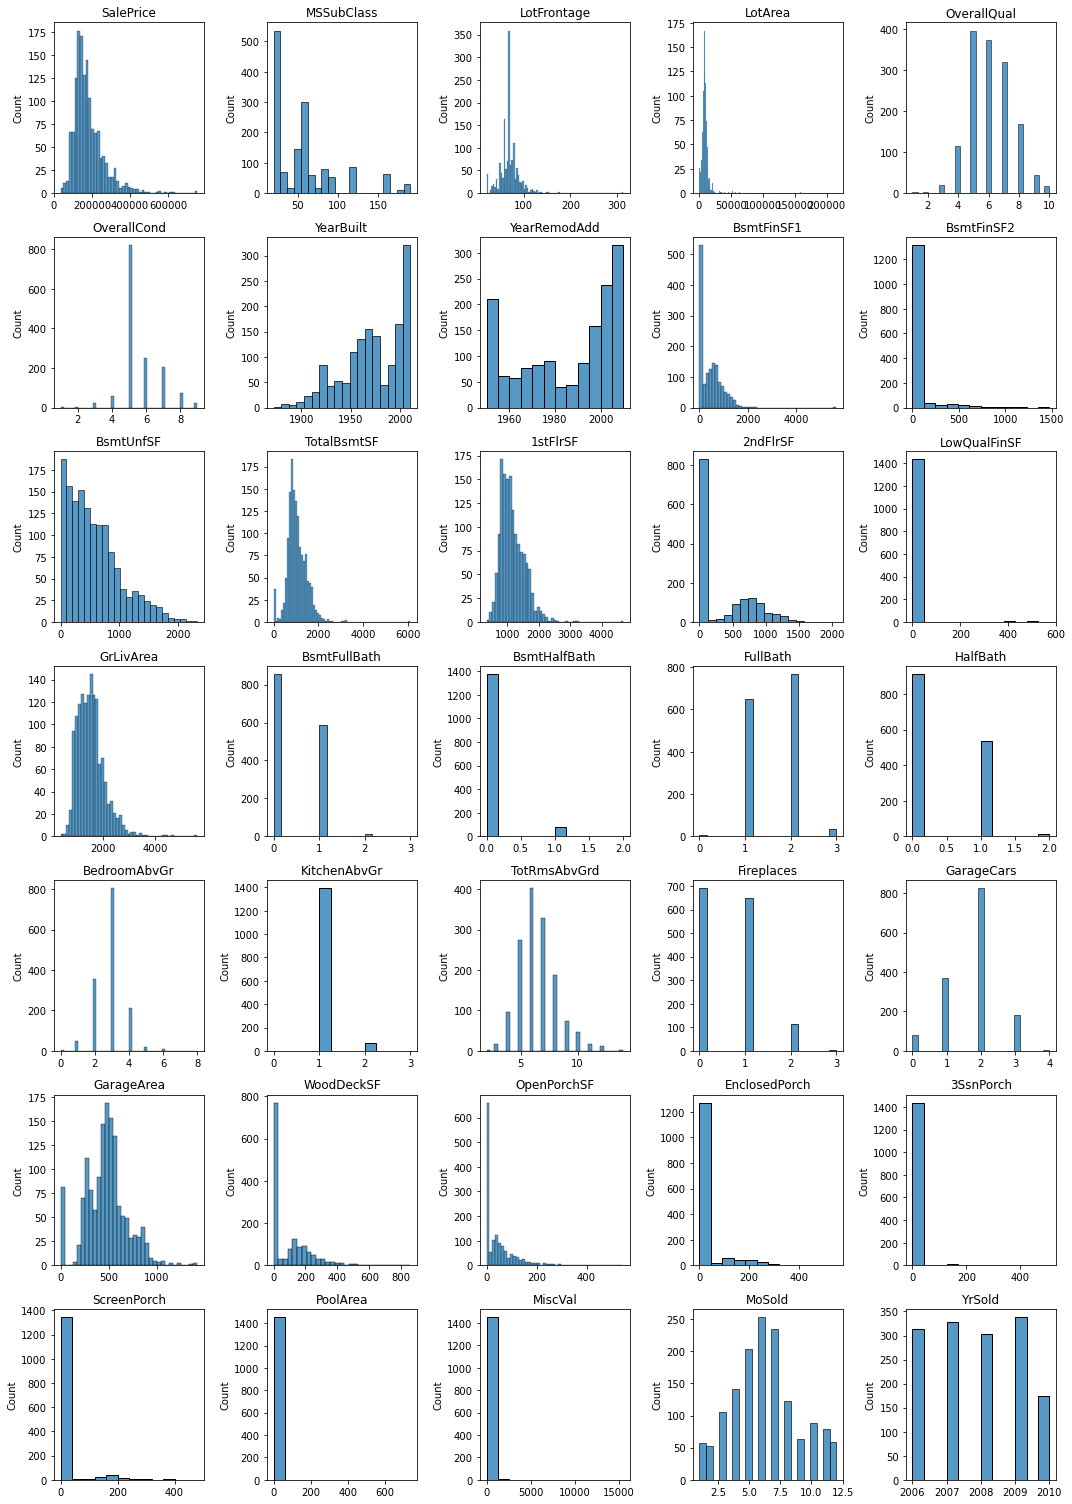

In [98]:
# function to iterate through num cols and create boxplots
def draw_hist_grid(df):
    num_cols = df.select_dtypes(include='number').columns
    num_plots = len(num_cols)
    num_rows = math.ceil(num_plots / 5)
    
    fig, axs = plt.subplots(num_rows, 5, figsize=(15, num_rows * 3))
    axs = axs.flatten()
    
    for i, column in enumerate(num_cols):
        ax = axs[i]
        sns.histplot(x=column, data=df, ax=ax)
        ax.set_title(column)
        ax.set_xlabel("")
    
    # remove any unused subplots
    if num_plots < len(axs):
        for j in range(num_plots, len(axs)):
            fig.delaxes(axs[j])
    
    plt.tight_layout()
    plt.show()

# look at boxplots for each except Id
draw_hist_grid(df_train.iloc[:,1:])

This gives us a bit more insight in the target, we can see its not that abormal. We can clearly see which variables are categorical numeric variables i.e. `YrSold`, `MoSold` etc... Some of the continuous numerical variables are close to normal such as `SalePrice`, `1stFlrSF`, `GrLivArea` and some are almost bimodel because they have 0 of something say for instance `BsmtFinSF1`. Furthermore, some are just right-skewed `BsmntUnfSF`.

These many different types of distributions make it hard to decide on a particular transformation, but we will leave that for later.

### Scatterplots
Let's look at a few scatterplots as well.

In [137]:
# custom function for scatter plot
def scat_abrev(df, x, y, xlabel, ylabel, title, suffix_y="k", x_scale=True, suffix_x=False, figsize=(10,7)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.set_theme("notebook")
    sns.regplot(data=df, x=x, y=y, ax=ax)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title, fontdict={"size":20})
    
    # abbrev y-lab
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f"{int(y/1000)}{suffix_y}"))

    # abbrev x-lab if True
    if x_scale:
        plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x/1000)}{suffix_x}"))
    else:
        pass
    plt.show()


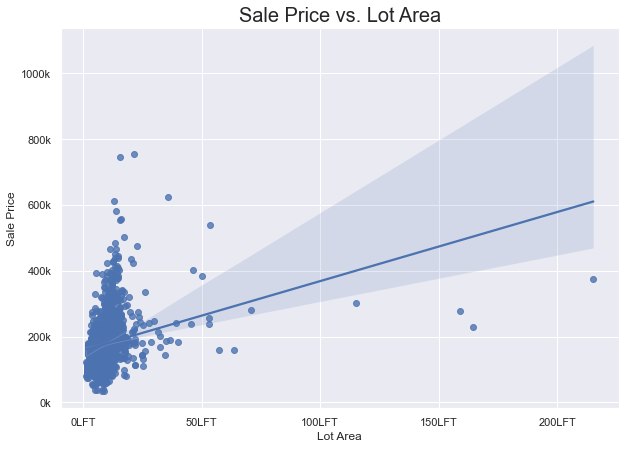

In [142]:
# target vs. lot area
scat_abrev(df_train, "LotArea", "SalePrice", "Lot Area", "Sale Price", "Sale Price vs. Lot Area", x_scale=True, suffix_x="LFT")

Slight linear relationship between `SalePrice` and `LotArea`.<br>
Let's try `YearBuilt`.

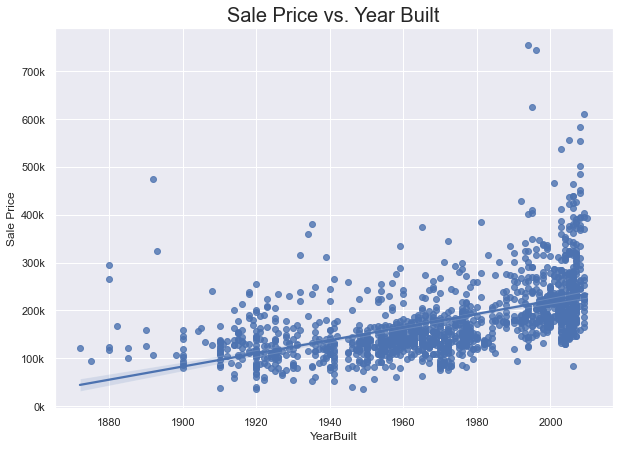

In [143]:
# target vs. lot area
scat_abrev(df_train, "YearBuilt", "SalePrice", "YearBuilt", "Sale Price", "Sale Price vs. Year Built", x_scale=False)

There is definetly a correlation between the target and `YearBuilt`.

### Scatter Matrix
Let's look at some scatter matrices.

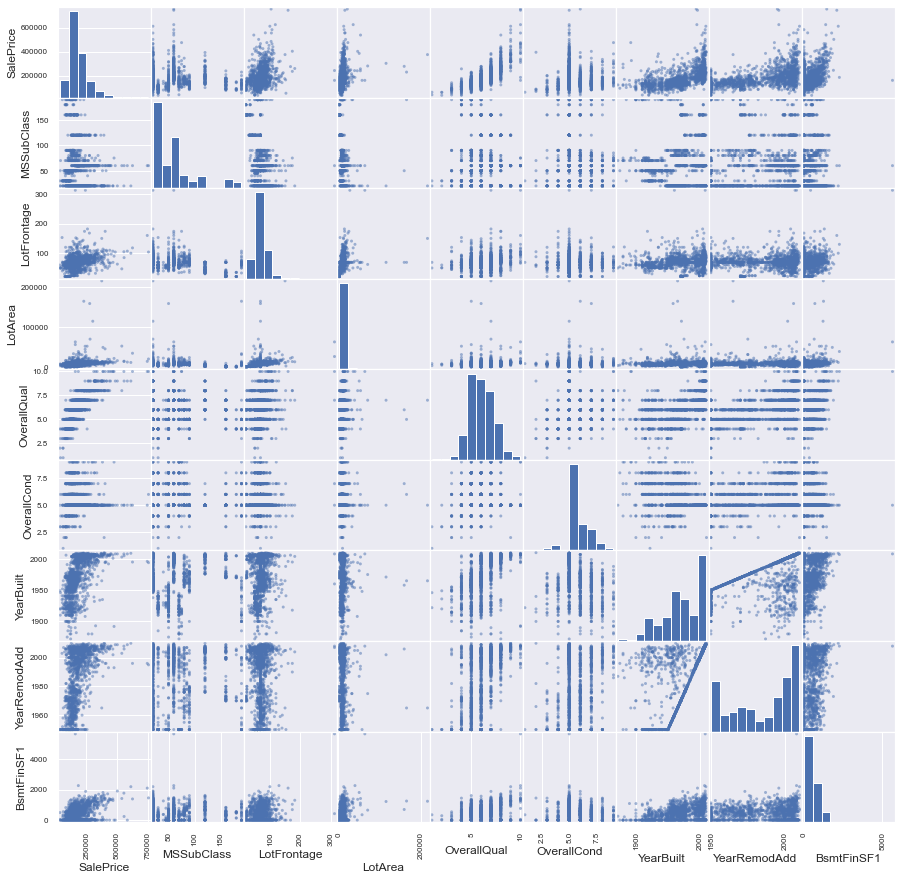

In [197]:
# first batch
pd.plotting.scatter_matrix(df_train.iloc[:,1:35], figsize=(15,15));

Positive relationship betwen `SalePrice` and `YearBuilt`, `SalePrice` and `OverallQual`, `SalePrice` and `YearremodAdd`, `SalePrice` and `LotFootage`

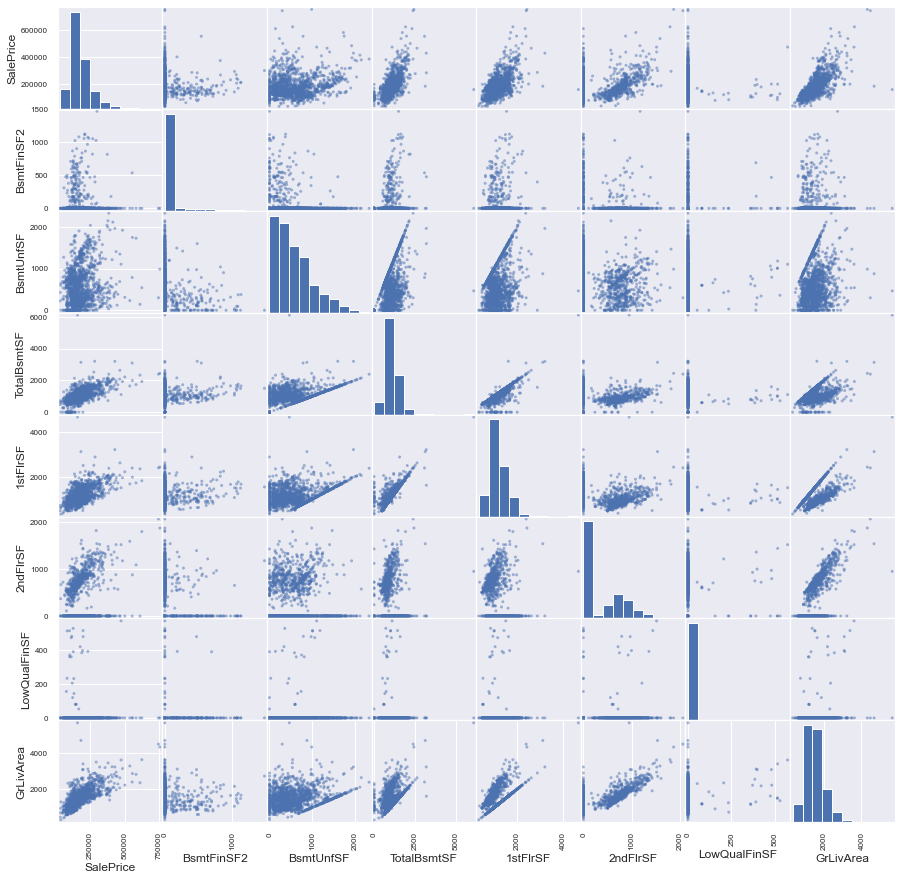

In [198]:
# define target and amount of cols
target_col = [1]
other_cols = list(range(36,47))

# plot next 25 with target
pd.plotting.scatter_matrix(df_train.iloc[:,target_col + other_cols], figsize=(15,15));

Also starting to see some multi-collineararity between variables such as `GrLivArea` and `2ndFlrSf`. Will have to do a correlation matrix check soon and prob end up dropping some collinear variables.

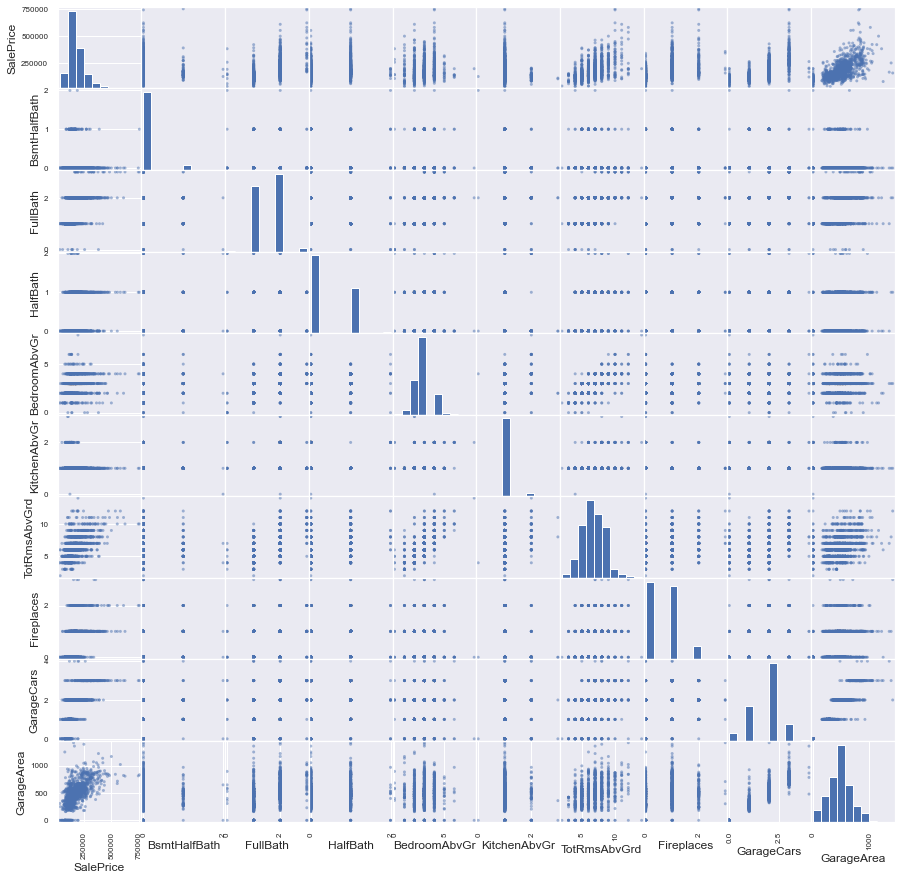

In [201]:
# last bunch
# define target and amount of cols
other_cols_2 = list(range(48,64))

# plot next 25 with target
pd.plotting.scatter_matrix(df_train.iloc[:,target_col + other_cols_2], figsize=(15,15));

Most features here are categorical and only a few such as `GarageArea` and `TotRmsAbvGrd` are normally distributed.<br>
Also seems to be a positive linear relationship between `GarageArea` and `SalePrice`.

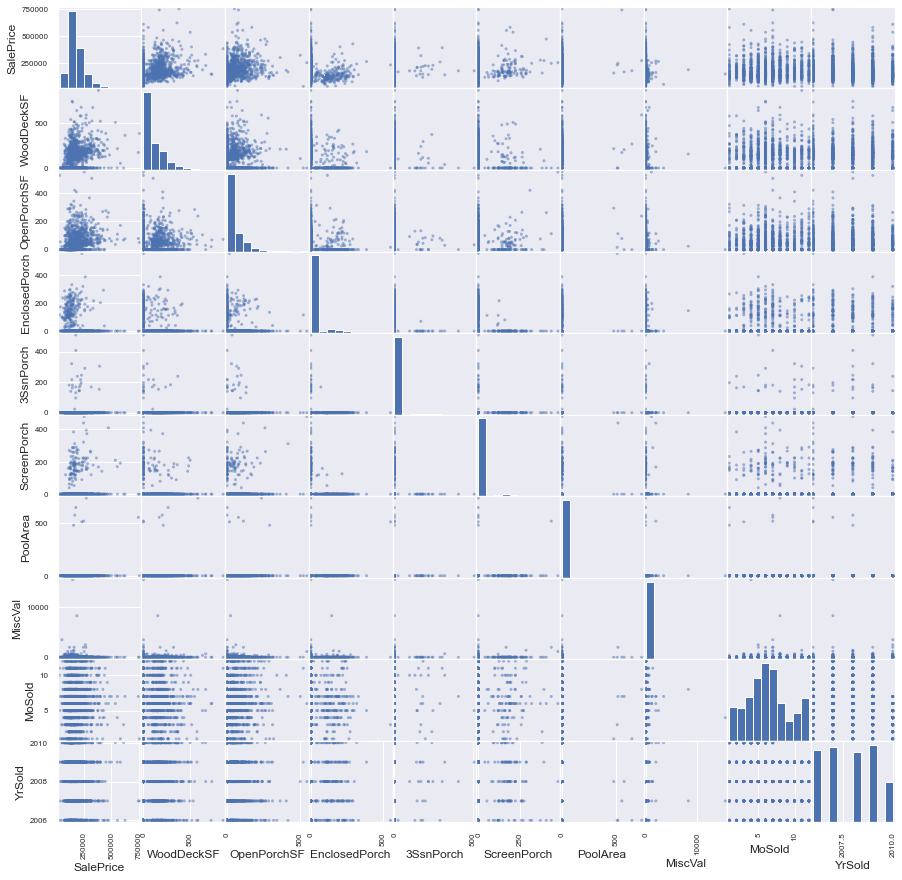

In [200]:
# last bunch
# define target and amount of cols
other_cols_3 = list(range(65,76))

# plot next 25 with target
pd.plotting.scatter_matrix(df_train.iloc[:,target_col + other_cols_3], figsize=(15,15));

All features in this matrix except perhaps the target `SalePrice` are not normally distributed.

### Correlation Matrix
Let's look at a few quanitative variables that could be correlated, `GrLivArea`, `2ndFlrSf` and `LotArea`

In [223]:
# Create a subset DataFrame with the selected variables
subset_df = df_train[['GrLivArea', '2ndFlrSF', 'LotArea']]

# Calculate the correlation matrix
correlation_matrix = subset_df.corr()

# calculate the p-values for the correlation coefficients
p_values = []
for col in correlation_matrix.columns:
    p_value = []
    for other_col in correlation_matrix.columns:
        if col != other_col:
            coefficient, p = pearsonr(subset_df[col], subset_df[other_col])
            p_value.append(p)
        else:
            p_value.append(0)  # setting p-value as 0 for the variable itself
    p_values.append(p_value)

# create a df with the correlation matrix and p-values
correlation_matrix_with_pvalues = pd.DataFrame(correlation_matrix.values, index=correlation_matrix.index, columns=correlation_matrix.columns)
correlation_matrix_with_pvalues['p-value'] = p_values
print(correlation_matrix_with_pvalues)

           GrLivArea  2ndFlrSF   LotArea  \
GrLivArea   1.000000  0.687501  0.263116   
2ndFlrSF    0.687501  1.000000  0.050986   
LotArea     0.263116  0.050986  1.000000   

                                                     p-value  
GrLivArea  [0, 7.724782361993936e-205, 1.5204806361384027...  
2ndFlrSF    [7.724782361993936e-205, 0, 0.05144265638444893]  
LotArea     [1.5204806361384027e-24, 0.05144265638444893, 0]  


Here we can see that `GrLivArea` and `2ndFlrSF` are pretty highly correlated at 0.68, whilst `LotArea` and `2ndFlrSF` are not at all with 0.05.<br>
In addition, we can see the extremely low p-value of 7.724782361993936e-205 between `GrLivArea` and `2ndFlrSF` indicate that the relationship is statistically significant. <br>
So because both with the high correlation score, and low p-value between `GrLivArea` and `2ndFlrSF`, we can say  it indicates a strong and statistically significant linear relationship between the variables.

In [230]:
# get the column names
column_names = correlation_matrix.columns.tolist()

# invert correlation matrix
correlation_matrix_array = np.array(correlation_matrix)

# calculate the precision matrix (inverse of the correlation matrix)
precision_matrix = np.linalg.inv(correlation_matrix_array)

# multiply the correlation matrix by the precision matrix
result1 = np.dot(correlation_matrix_array, precision_matrix)

# multiply the precision matrix by the correlation matrix
result2 = np.dot(precision_matrix, correlation_matrix_array)

# perform LU decomposition on the matrix
lu_decomposition = lu(correlation_matrix_array)

# Print the results with column names
print("Precision Matrix:")
precision_df = pd.DataFrame(precision_matrix, columns=column_names, index=column_names)
print(precision_df)

Precision Matrix:
           GrLivArea  2ndFlrSF   LotArea
GrLivArea   2.104404 -1.422246 -0.481188
2ndFlrSF   -1.422246  1.963821  0.274089
LotArea    -0.481188  0.274089  1.112634


Higher values in the precision matrix indicate lower multicollinearity between the variables, suggesting that they are less dependent on each other whereas, lower values indicate the opposite.
We can see this is lower for `GrLivArea` and `2ndFlrSF`, and higher for `LotArea` and `2ndFlrSF` indicating higher and lower multicollinearity respectively.

In [231]:
print("\nCorrelation Matrix multiplied by Precision Matrix:")
result1_df = pd.DataFrame(result1, columns=column_names, index=column_names)
print(result1_df)


Correlation Matrix multiplied by Precision Matrix:
              GrLivArea      2ndFlrSF       LotArea
GrLivArea  1.000000e+00 -9.639085e-17  9.507878e-18
2ndFlrSF  -5.907984e-17  1.000000e+00 -5.725447e-17
LotArea    0.000000e+00 -5.551115e-17  1.000000e+00


Non-zero values in this matrix indicate the strength and direction of the partial correlations between variables after accounting for multicollinearity.<br>
Again, we can see `GrLivArea` and `2ndFlrSF` are correlated.

In [232]:

print("\nPrecision Matrix multiplied by Correlation Matrix:")
result2_df = pd.DataFrame(result2, columns=column_names, index=column_names)
print(result2_df)


Precision Matrix multiplied by Correlation Matrix:
              GrLivArea      2ndFlrSF       LotArea
GrLivArea  1.000000e+00 -2.811244e-16  0.000000e+00
2ndFlrSF   1.110479e-16  1.000000e+00 -5.551115e-17
LotArea    9.507878e-18 -1.743322e-18  1.000000e+00


Multiplying the precision matrix by the correlation matrix yields a matrix that measures the influence of each variable on all other variables.<br>
Non-zero values in this matrix represent the standardized regression coefficients or partial regression coefficients.<br>
Here we can see that `GrLivArea` and `2ndFlrSF` have a slight negative relationship when compared to all values in the matrix.

In [233]:
print("\nLU Decomposition:")
print("L Matrix:")
l_matrix = lu_decomposition[1]
l_df = pd.DataFrame(l_matrix, columns=column_names, index=column_names)
print(l_df)


LU Decomposition:
L Matrix:
           GrLivArea  2ndFlrSF  LotArea
GrLivArea   1.000000  0.000000      0.0
2ndFlrSF    0.687501  1.000000      0.0
LotArea     0.263116 -0.246342      1.0


The diagonal elements of the U matrix provide information about the variance explained by each variable individually. Larger values indicate variables that explain more variance in the dataset, whereas smaller values suggest variables with lower explanatory power.<br>
Here we can see that `GrLivArea` has highest value, whereas `2ndFlrSF` the lowest.<br>

The U matrix can also provide insights into the importance of variables in explaining the overall correlation structure. Variables with larger coefficients in the U matrix can be considered more influential in driving the correlations observed in the data.<br>
Here we can see that `GrLivArea` has highest value


In [234]:

print("\nU Matrix:")
u_matrix = lu_decomposition[2]
u_df = pd.DataFrame(u_matrix, columns=column_names, index=column_names)
print(u_df)


U Matrix:
           GrLivArea  2ndFlrSF   LotArea
GrLivArea        1.0  0.687501  0.263116
2ndFlrSF         0.0  0.527342 -0.129907
LotArea          0.0  0.000000  0.898768


## Create Dummy Variables
Create a list of all categorical values in dataframe and create dummy variables.

In [ ]:
# create list of categorical columns
categorical_columns = []

for column in df_train.columns:
    if np.issubdtype(df_train[column].dtype, np.number):  # check if the column has a numerical data type
        unique_values = df_train[column].nunique()
        if unique_values <= 10:  # set a threshold to consider it as a numerical categorical variable
            categorical_columns.append(column)
    elif df_train[column].dtype == 'object':  # check if the column has the 'object' data type
        categorical_columns.append(column)


Everything looks good except for `PoolArea`, will drop that from list.

In [209]:
# drop PoolArea
categorical_columns.remove('PoolArea')

In [213]:
# create dummy variables
df_train_encoded = pd.get_dummies(df_train, columns=categorical_columns, drop_first=True)

## Outlier Check
Will look at all numerical values and trim outliers.<br>
Let's first take a look at numerical values.

In [244]:
df_train["MSSubClass"].value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

In [243]:
df_train.loc[:, ~df_train.columns.isin(categorical_columns)]

,Id,SalePrice,MSSubClass,LotFrontage,LotArea,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,TotRmsAbvGrd,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold
0,1,208500,60,65.0,8450,2003,2003,706,0,150,856,856,854,0,1710,8,548,0,61,0,0,0,0,0,2
1,2,181500,20,80.0,9600,1976,1976,978,0,284,1262,1262,0,0,1262,6,460,298,0,0,0,0,0,0,5
2,3,223500,60,68.0,11250,2001,2002,486,0,434,920,920,866,0,1786,6,608,0,42,0,0,0,0,0,9
3,4,140000,70,60.0,9550,1915,1970,216,0,540,756,961,756,0,1717,7,642,0,35,272,0,0,0,0,2
4,5,250000,60,84.0,14260,2000,2000,655,0,490,1145,1145,1053,0,2198,9,836,192,84,0,0,0,0,0,12
5,6,143000,50,85.0,14115,1993,1995,732,0,64,796,796,566,0,1362,5,480,40,30,0,320,0,0,700,10
6,7,307000,20,75.0,10084,2004,2005,1369,0,317,1686,1694,0,0,1694,7,636,255,57,0,0,0,0,0,8
7,8,200000,60,69.0,10382,1973,1973,859,32,216,1107,1107,983,0,2090,7,484,235,204,228,0,0,0,350,11
8,9,129900,50,51.0,6120,1931,1950,0,0,952,952,1022,752,0,1774,8,468,90,0,205,0,0,0,0,4
9,10,118000,190,50.0,7420,1939,1950,851,0,140,991,1077,0,0,1077,5,205,0,4,0,0,0,0,0,1


In [240]:
num_columns

['Id',
 'SalePrice',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'TotRmsAbvGrd',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'MiscVal',
 'MoSold']

In [83]:
# list of numeric cols
num_cols=['LotFrontage', 'LotArea', 'BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF', 
          '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea','GarageArea', 'WoodDeckSF', 
          'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

Bring any values from numerical columns 6 standard deviation above mean down to 6 standard deviations

In [84]:
# iterate through noncategorical numerical features 
for col in num_cols: 
    above_6std = df_train[col].mean()+(6*df_train[col].std())

    # if outliers are above 6 standard devs, reduce to 6 standard devs from mean
    df_train[col] = np.where(df_train[col].values >above_6std, 
                             df_train[col].mean()+6*df_train[col].std(), 
                             df_train[col])

### Baseline Model


In [85]:
y = df_train[['SalePrice']]
X = df_train.iloc[:,2:]
baseline = LinearRegression()
baseline.fit(X,y)
baseline.score(X,y)

ValueError: could not convert string to float: 'RL'

In [ ]:
# # sort sale price descending
# df_train.sort_values('SalePrice', ascending=False).head(10)